# **Edges**

- Stephen Welch
- UNCC Computer Vision

**Required Reading/Viewing:**

1. [Roberts, Lawrence G. Machine perception of three-dimensional solids. Diss. Massachusetts Institute of Technology, 1963." Pages 25-27](https://dspace.mit.edu/bitstream/handle/1721.1/11589/33959125-MIT.pdf?sequence=2)
2. [Minute Physics - Computer Color is Broken](https://www.youtube.com/watch?v=LKnqECcg6Gw)

**Optional Reading/Viewing**
1. [John Novak's excellent blog post on gamma](http://blog.johnnovak.net/2016/09/21/what-every-coder-should-know-about-gamma/)


Recommended [Jupyter Theme](https://github.com/dunovank/jupyter-themes) for presenting this notebook:
````
jt -t grade3 -cellw=90% -fs=20 -tfs=20 -ofs=20
````

![](videos/brick_ball_cylinder.gif)

# How can we extract meaningful information from images like these?

- Let's borrow some great early ideas from the work of MIT graduate student **Lawrence Roberts**. 

![](graphics/roberts_thesis-01.png)

- Robert's phD thesis delt with constructing three dimensional models of solids from single photographs, these models could then be rotated and the solid could be viewed from any perspective. 
- Interestingly, Roberts next job was the ["...manager and principal architect of the precursor to the Internet."](https://www.ibiblio.org/pioneers/roberts.html)
- Robert's approach begins with extracting a "line drawing" or finding the edges of the solid. 
- We'll have a closer look at Robert's approach, but we first need some data!



Let's see if we can make sense of this equation, but first we need some data to work with.

In [1]:
#ipython magic numpy and matplotlib import function
%pylab inline 

Populating the interactive namespace from numpy and matplotlib


In [2]:
#Load image
im = imread('data/easy/bricks/brick_1.jpg')

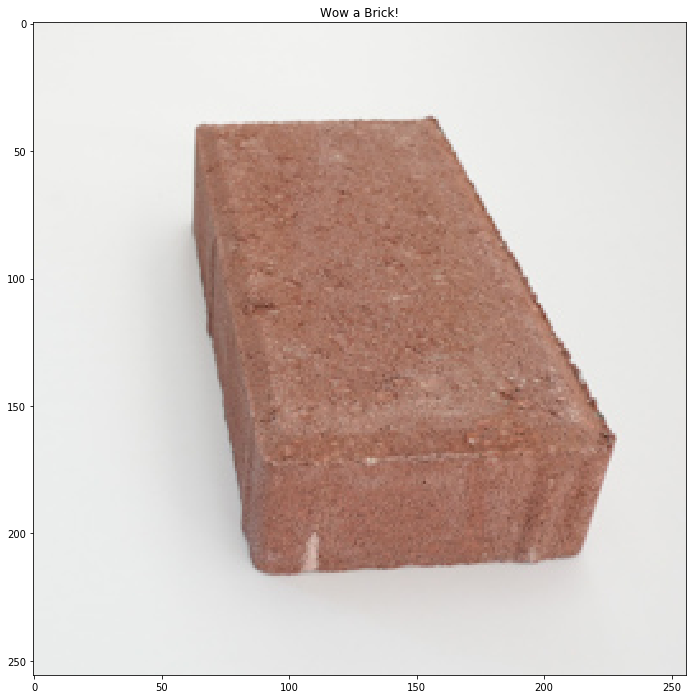

In [3]:
#Display Image
fig = figure(0, (12,12))
imshow(im); title('Wow a Brick!');

In [4]:
im.shape

(256, 256, 3)

In [5]:
im.dtype

dtype('uint8')

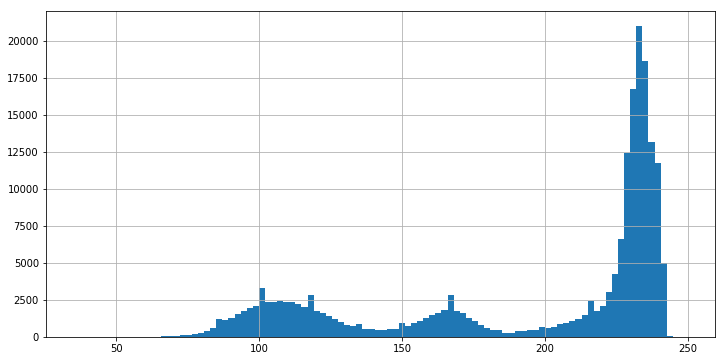

In [6]:
#It's generally a good idea to get a feel for the distribution of data
fig = figure(0, (12,6))
hist(im.ravel(), 100); grid(1)

Now, before we dive too deep into Robert's Equations, let's make two modifications to our image. 

**1. Scaling ** Our image is currently scaled between 0 and 255. There are very good reasons for this - many images, including ours, are stored as 8 bit unsigned integers - this saves space, as we only need 8 bits of storage for each pixel. However, often (but not always), it will be easier to work with our images if we first scale them between 0 and 1. Note that this scaling will require us to change to a floating datatype.

**2. Grayscale ** Our image is currently color, but the images Roberts would have worked with were grayscale, and further it's often useful to convert images to grayscale to simplify processing - we'll do this quite often. In fact, we're going to do it so often that we should write a method for it.

In [7]:
#scale image between 0 and 1
im_scaled = im/255

In [8]:
im_scaled.dtype

dtype('float64')

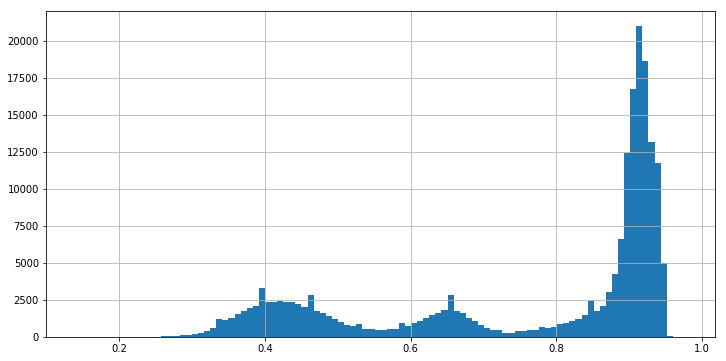

In [9]:
#It's generally a good idea to get a feel for the distribution of data
fig = figure(0, (12,6))
hist(im_scaled.ravel(), 100); grid(1)

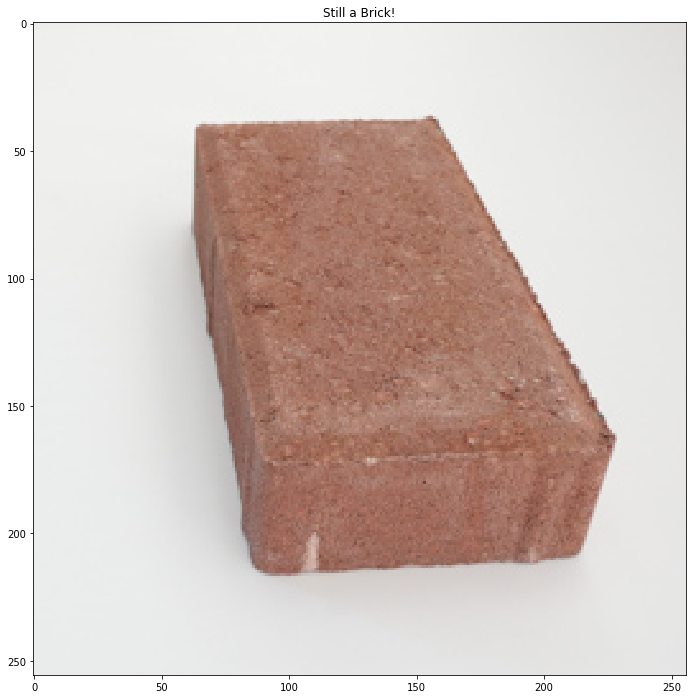

In [10]:
fig = figure(0, (12,12))
imshow(im_scaled); title('Still a Brick!');

We'll be doing this fairly often, so let's go ahead and write a method to convert floating point images to grayscale:

In [12]:
def convert_to_grayscale(im):
    '''
    Convert color image to grayscale.
    Args: im = (nxmx3) floating point color image scaled between 0 and 1
    Returns: (nxm) floating point grayscale image scaled between 0 and 1
    '''
    return np.mean(im, axis = 2)

In [13]:
#We'll use Robert's notation, and call our grayscale image x
x = convert_to_grayscale(im_scaled)

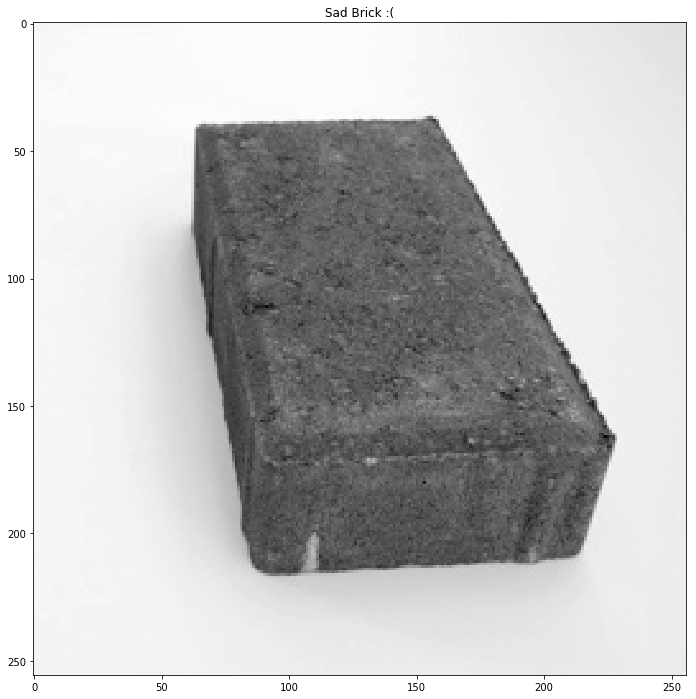

In [14]:
fig = figure(0, (12,12))
imshow(x, cmap = 'gray'); title('Sad Brick :(');

## **Ok, so how did Robert's find edges way back in 1963?**

___

![](graphics/roberts_equations.png)

___

- Roberts first took the square root of the intensity values ("Gamma correcting the image") to take into account the non-linear human perception of color intensities
- To extract the edges of the solid, Roberts then used a **"Local differential operator."**

Let's take these operations one at a time, starting with the gamma correction:

## $$
y_{i, j} = \sqrt {x_{i, j}}
$$

What Roberts is trying to do here is to account for the inherent [nonlinear nature of human sight](https://en.wikipedia.org/wiki/Stevens%27s_power_law): 

---

*"In order to make equally apparent images have equal derivatives, the intensity values of the picture can be subject to a gamma change so as to make the intensity differences proportional to a human's ability to percieve them. According to physchophysical theory, the square root of the intensities should be used in order to achieve the desired effect."*

---

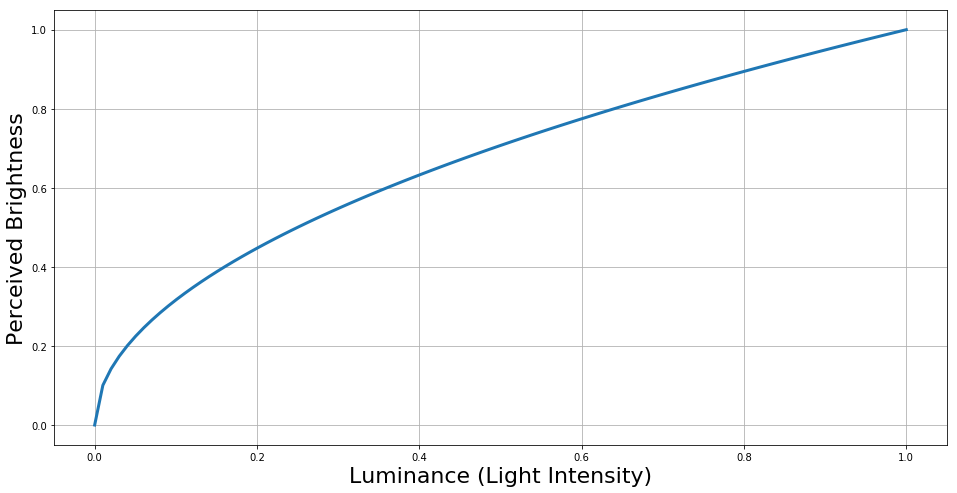

In [14]:
#Quick plot to visualize the relationship between actual and perceived light intensity.
fig = figure(0, (16,8))
xs = np.linspace(0, 1, 100)
plot(xs, np.sqrt(xs), linewidth = 3); grid(1); 
xlabel('Luminance (Light Intensity)', fontsize = 22);
ylabel('Perceived Brightness', fontsize = 22);

Let's make sure this idea makes sense, it can be a little subtle - and will definitely show up again. We can rephrase Robert's idea here as: 



# Edges that have **equal contrast** to our eyeballs should have equal numerical **intensity differences **

Let's do a quick test...

In [54]:
from IPython.display import Image, display
from IPython.html.widgets import interact

#Quick method to let me step through "slides"
def slide_show(slide_num):     
    display(Image('graphics/gamma_slides/' + str(slide_num).zfill(2) + '.png'))

In [55]:
interact(slide_show, slide_num = (1, 2));

A Jupyter Widget

___

- So, the left image above is **linear**. the difference between each pair of large/small squares is 16. 
- The image on the right is computed using Robert's suggestion of taking the square root of the RGB values. 
    - If you're paying attention, you may notice that the values on the right **do not** appear to be the square roots of the values on the right. 
- Now to me (and hopefully to you, your computer monitor may be throwing things off) the image on the left **appears to have more consistent** contrast across it's edges.

Gosh gamma is tricky!

    - The idea here is that edges that appear equally strong to humans should have equivalent intensity differences after we take the square root

Ok, we now have an image that should be pretty similar to what Roberts would have been workign with (although ours is undoubtedly much higher quality). Now, let's apply Robert's first operation, the square root. Why did he do this again?

## $$
y_{i, j} = \sqrt {x_{i, j}}
$$

I think I would like to say something about gamma here, maybe show some visuals - it's a pretty interesting topic!

* $\gamma$ issue - so...I can't figure out if I'm working in linear or gamma space. I've got some ideas, but for now I'm going to pause on this and see If I can knock out the two goals I set up for myself. And for now, let's go a ahead and assume that y is in linear space.

In [15]:
## Easy!
y = np.sqrt(x)

In [16]:
y.shape

(256, 256)

In [17]:
y.dtype

dtype('float64')

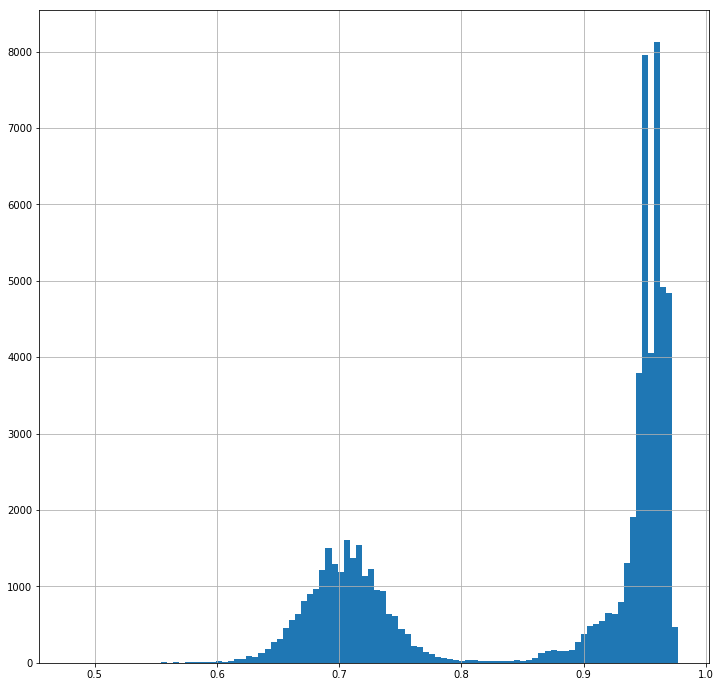

In [18]:
fig = figure(0, (12,12))
hist(y.ravel(), 100); grid(1);

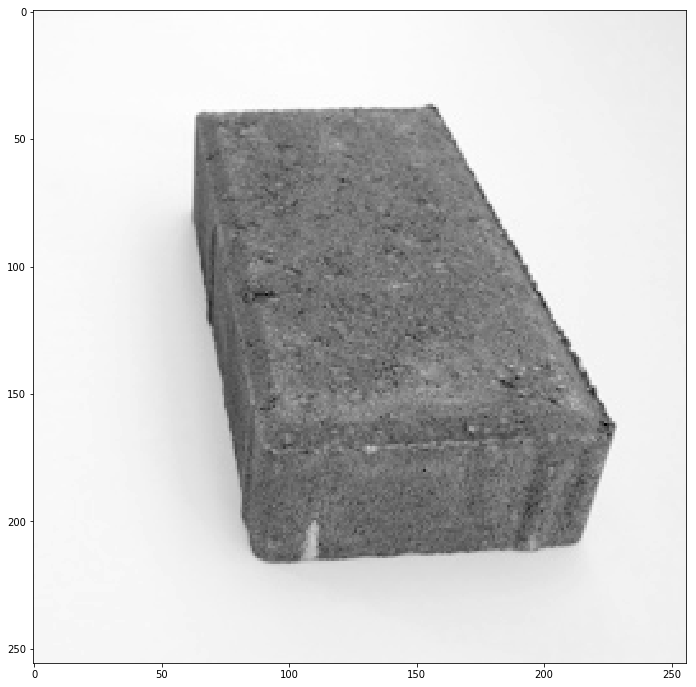

In [19]:
fig = figure(0, (12,12))
imshow(y, cmap = 'gray'); 